In [1]:
import qgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
import h5py

### hapROH imports
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")  # hack to get development package first in path
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/hapBLOCK/IO/")  # hack to get development package first in path
from h5_load import get_coverage,get_genos_pairs,get_idx_iid,get_markers_good

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0, path)

compute-a-17-74.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


### Analyze the Relatedness

In [2]:
def new_column(df, df_meta, col="New Clade", col_new="", match_col="iid"):
    """Maps Entries from meta dataframe onto the IBD dataframe.
    Return modified dataframe"""
    if len(col_new)==0:
        col_new=col
    dct = pd.Series(df_meta[col].values, index=df_meta[match_col]).to_dict()
    
    for i in range(1,3):    
        df[col_new + str(i)] =df["iid" + str(i)].map(dct)
        df[col_new + str(i)] =df["iid" + str(i)].map(dct)
    return df

In [109]:
df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v43.4.anno.csv", sep=",")  # Load Meta File

print(f"Loaded Metafile {len(df_meta)} iids")

df = pd.read_csv("./output/relatives_snp/opp_homos_ch3.tsv", sep="\t")
print(f"Loaded {len(df)} PO or identical Individuals")

df1 = new_column(df, df_meta, col='Master ID')
df1 = new_column(df, df_meta, col="n_cov_snp")
df1 = new_column(df1, df_meta, col="age")
df1 = new_column(df1, df_meta, col="study")
df1 = new_column(df1, df_meta, col="clst")
df1 = new_column(df1, df_meta, col="family")
#df1["delta_age"] = np.abs(df1["age1"] - df1["age2"])
df1['relatedness'] = "Parent Offspring"
df1.loc[df1["gt_match_rate_ch3"]>0.95, "relatedness"] = "Identical"
df1 = df1[df1["frac_snps_good_ch3"]>0.43]
len(df1)

Loaded Metafile 18171 iids
Loaded 1603 PO or identical Individuals


1593

In [ ]:
df1.sort_values(by="gt_match_rate_ch3", ascending=False)[:50]

In [112]:
df1.to_csv("./output/relatives_snp/opp_homos_ch3_processed_all.tsv", sep="\t", index=False)

# QC

In [113]:
idx_same = df1["Master ID1"] == df1["Master ID2"]
df1[idx_same]["relatedness"].value_counts()

Identical    1007
Name: relatedness, dtype: int64

In [120]:
df1["relatedness"].value_counts()

Identical           1183
Parent Offspring     410
Name: relatedness, dtype: int64

In [ ]:
df1[df1["relatedness"]=="Parent Offspring"].sort_values(by="age1")

# Fish out new relationships

In [114]:
idx_same = df1["Master ID1"] == df1["Master ID2"]
df2 = df1[~idx_same]
df2 = df2.sort_values(by="frac_snps_good_ch3", ascending=False)
df2=df2.drop_duplicates(subset=['Master ID1', 'Master ID2'])
df2 = df2[df2["frac_snps_good_ch3"]>0.43]
df2.to_csv("./output/relatives_snp/opp_homos_ch3_processed_uniqye.tsv", sep="\t", index=False)
len(df2)

499

## New Relationships

In [115]:
idx_new = df2["family1"].str.contains("n/a") | df2["family2"].str.contains("n/a")

In [118]:
df3=df2[idx_new]
df3 = df3[df3["frac_snps_good_ch3"]>0.43]
df3.to_csv("./output/relatives_snp/opp_homos_ch3_processed_unique_novel.tsv", sep="\t", index=False)
len(df3)

185

In [ ]:
df3[:50]

In [ ]:
df3[df3["relatedness"]=="Parent Offspring"]

In [99]:
df3["relatedness"].value_counts()

Identical           162
Parent Offspring     23
Name: relatedness, dtype: int64

In [72]:
df_meta[df_meta["iid"].str.contains("I18945")]

,iid,Master ID,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family
6144,I18945,I18945,NaN,NaN,4350.0,Italy,Unpublished (Alissa broad Italian transect),Italy_Sardinia_EBA_dup.SUC009,0.702418,842902,4.818,True,n/a (no relatives detected)


In [107]:
df3[df3["study2"].str.contains("Caribbean")]

,iid1,iid2,opp_homo_rate_ch3,gt_match_rate_ch3,frac_snps_good_ch3,Master ID1,Master ID2,n_cov_snp1,n_cov_snp2,age1,age2,study1,study2,clst1,clst2,family1,family2,relatedness


In [158]:
df3["study1"].value_counts()

Unpublished / Unclaimed                                                                                                     60
FlegontovNature2019                                                                                                         21
Unpublished (TC and Vagheesh and Alex Seima Turbino and Uralic)                                                             14
Unpublished (Anthony Patterson Yamnaya)                                                                                     14
Unpublished (Alissa broad Italian transect)                                                                                 10
DamgaardNature2018                                                                                                           8
Unpublished (Nick Michael Britain BA to IA)                                                                                  6
SikoraNature2019                                                                                               

In [160]:
df3[df3["study1"].str.contains("DamgaardNature2018")]

,iid1,iid2,opp_homo_rate_ch3,gt_match_rate_ch3,frac_snps_good_ch3,Master ID1,Master ID2,n_cov_snp1,n_cov_snp2,age1,age2,study1,study2,clst1,clst2,family1,family2,relatedness
996,DA222.SG,I12117,0.000000,0.999078,0.902915,DA222,I12117,1091284,712831,1100.0,850.0,DamgaardNature2018,Unpublished (Arie Kipchaks and Mongols),Kazakhstan_Karluk_1.SG,Kazakhstan_Hun_Alan_possible,n/a (no relatives detected),"Kazakhstan, Butakty Family A (2 members) (I121...",Identical
997,DA227.SG,I11525,0.000000,0.766589,0.900149,DA227,I11525,645884,782057,2200.0,2150.0,DamgaardNature2018,Unpublished / Unclaimed,Kazakhstan_WUSUN_o.SG,Kazakhstan_LateSaka,n/a (no relatives detected),n/a (no relatives detected),Parent Offspring
995,DA220.SG,I10519,0.000000,0.999232,0.891900,DA220,I10519,333885,805667,2200.0,2150.0,DamgaardNature2018,Unpublished / Unclaimed,Kazakhstan_Wusun.SG,Kazakhstan_LateSaka,n/a (no relatives detected),n/a (no relatives detected),Identical
998,DA229.SG,I10514,0.000000,0.999419,0.885193,DA229,I10514,476291,804588,1700.0,1683.0,DamgaardNature2018,Unpublished (Arie Western Steppe 1000 BCE - 10...,Kazakhstan_Kangju.SG,Kazakhstan_Kangju_o1,n/a (no relatives detected),n/a (no relatives detected),Identical
999,DA230.SG,I12116,0.000000,0.998891,0.882745,DA230,I12116,740013,758401,1100.0,850.0,DamgaardNature2018,Unpublished (Arie Kipchaks and Mongols),Kazakhstan_Karluk_2.SG,Kazakhstan_QARA_Hazara_Uyghur_possible_o,n/a (no relatives detected),n/a (no relatives detected),Identical
993,DA204.SG,I12113,0.000000,0.998835,0.882182,DA204,I12113,633817,726428,998.0,850.0,DamgaardNature2018,Unpublished (Arie Kipchaks and Mongols),Kazakhstan_Karakhanid.SG,Kazakhstan_Hun_Alan_possible,n/a (no relatives detected),n/a (no relatives detected),Identical
994,DA205.SG,I12112,0.000287,0.785928,0.852023,DA205,I12112,424419,719507,1000.0,850.0,DamgaardNature2018,Unpublished (Arie Kipchaks and Mongols),Kazakhstan_Karakhanid_o.SG,Kazakhstan_Hun_Alan_possible,n/a (no relatives detected),n/a (no relatives detected),Parent Offspring
991,DA201.SG,I11524,0.000000,0.999348,0.788622,DA201,I11524,232912,567765,2124.0,2150.0,DamgaardNature2018,Unpublished / Unclaimed,Kazakhstan_Wusun.SG,Kazakhstan_LateSaka,n/a (no relatives detected),n/a (no relatives detected),Identical


In [129]:
df3[np.abs(df3["age1"]-df3["age2"])>500]

,iid1,iid2,opp_homo_rate_ch3,gt_match_rate_ch3,frac_snps_good_ch3,Master ID1,Master ID2,n_cov_snp1,n_cov_snp2,age1,age2,study1,study2,clst1,clst2,family1,family2,relatedness
1540,I20477,I20464,0.000000,0.999924,0.960393,I20477,I20464,895809,1005124,2800.0,0.0,Unpublished / Unclaimed,Unpublished / Unclaimed,Brazil_LateHolocene_PrePotteryANDItararePottery,Brazil_LateHolocene_PrePotteryANDItararePottery,n/a (no relatives detected),n/a (no relatives detected),Identical
1568,I20808,I18115,0.000000,0.999948,0.947663,I20808,I18115,859900,936159,5950.0,4250.0,Unpublished (Iosif Southern Arc),Unpublished (Iosif Southern Arc),Romania_C_Bodrogkeresztur_o,Romania_C_Bodrogkeresztur,n/a (no relatives detected),n/a (no relatives detected),Identical
182,BR2.SG,I18209,0.000000,0.774574,0.909990,I1504,I18209,1182644,739651,3140.0,5450.0,GambaNatureCommunications2014,Unpublished (Pere Gelabert LBK),Hungary_LBA_Kyjatice.SG,Hungary_unknown,n/a (no relatives detected),n/a (no relatives detected),Parent Offspring
341,I1964,I12694,0.000000,0.999260,0.893026,I1964,I12694,784079,885711,6518.0,5450.0,Unpublished (TC and Vagheesh and Alex Seima Tu...,Unpublished (TC and Vagheesh and Alex Seima Tu...,Russia_WestSiberia_N,Russia_Bolshemys_N,n/a (no relatives detected),n/a (no relatives detected),Identical
920,I10141,DA224.SG,0.000000,0.999091,0.888301,I10141,DA224,738740,598896,2850.0,1613.0,Unpublished (Arie Western Steppe 1000 BCE - 10...,DamgaardNature2018,Kazakhstan_Kangju_LateSarmatian_possible,Kazakhstan_Turk_o.SG,n/a (no relatives detected),n/a (no relatives detected),Identical
1199,I12728,I12718,0.000000,0.999917,0.888277,I12728,I12718,696966,806600,875.0,2531.0,Unpublished / Unclaimed,Unpublished / Unclaimed,Argentina_CordobaHills,Argentina_CordobaPlains_2600BP,n/a (no relatives detected),n/a (no relatives detected),Identical
1523,SUC009,I18945,0.000000,0.999446,0.884091,SUC009,I18945,768042,842902,3710.0,4350.0,MarcusNatureCommunications2020,Unpublished (Alissa broad Italian transect),Italy_Sardinia_EBA,Italy_Sardinia_EBA_dup.SUC009,n/a (no relatives detected),n/a (no relatives detected),Identical
1569,I20807_d,I18117_d,0.000000,0.999972,0.882426,I20807,I18117,173357,179979,5950.0,4250.0,Unpublished (Iosif Southern Arc),Unpublished (Iosif Southern Arc),Romania_C_Bodrogkeresztur,Romania_C_Bodrogkeresztur_possible.dup.I18154_...,n/a (no relatives detected),"Romania, Urziceni Family B (2 members) (I18117...",Identical
1485,I7792,I20762,0.000000,0.999357,0.876111,I7792,I20762,997187,563737,4672.0,2950.0,Unpublished (TC and Vagheesh and Alex Seima Tu...,Unpublished (TC and Vagheesh and Alex Seima Tu...,Russia_BA_Central,Russia_Central_BA,n/a (no relatives detected),n/a (no relatives detected),Identical
1396,I16762,R19.SG,0.000000,0.999468,0.873712,I16762,R19,729175,498407,4450.0,7233.0,Unpublished (Alissa broad Italian transect),AntonioGaoMootsScience2019,Italy_South_C_Laterza,Italy_N.SG,n/a (no relatives detected),n/a (no relatives detected),Identical


# Figures

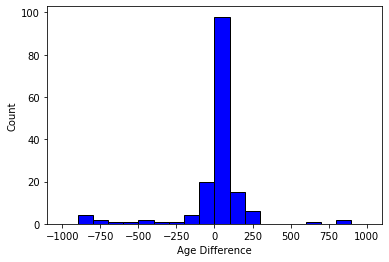

In [132]:
plt.figure()
bins=np.linspace(-1000,1000,21)
ax=plt.gca()
ax.hist(df3["age1"] - df1["age2"], ec="k", color="b", bins=bins)
ax.set_xlabel("Age Difference")
ax.set_ylabel("Count")
plt.show()

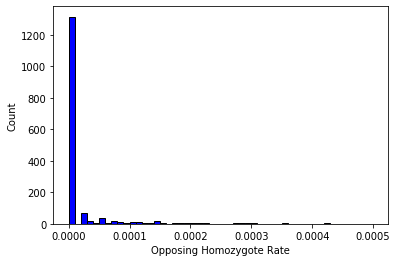

In [15]:
plt.figure()
bins=np.linspace(0,0.0005,51)
#bins=np.linspace(-500,500,21)
ax=plt.gca()
ax.hist(df1["opp_homo_rate_ch3"], ec="k", color="b", bins=bins)
ax.set_xlabel("Opposing Homozygote Rate")
ax.set_ylabel("Count")
plt.show()

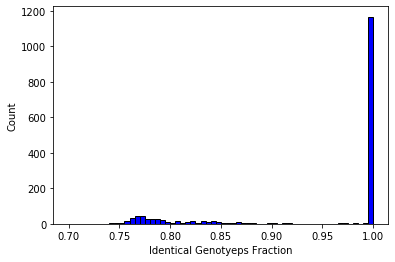

In [18]:
plt.figure()
bins=np.linspace(0.7,1.0,61)
ax=plt.gca()
ax.hist(df1["gt_match_rate_ch3"], ec="k", color="b", bins=bins)
ax.set_xlabel("Identical Genotyeps Fraction")
ax.set_ylabel("Count")
plt.show()